In [5]:
# train_resnet.py
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models


In [6]:
# --- 설정 ---
TRAIN_DIR = '/home/work/AIprogramming/Ai_proj/data_generator/train_data'
TEST_DIR  = '/home/work/AIprogramming/Ai_proj/data_generator/test_data'
CHECKPOINT_DIR = './checkpoints'
HISTORY_CSV    = './history.csv'
BATCH_SIZE = 128
EPOCHS     = 100
LR         = 1e-3
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
def load_pt_folder(pt_dir):
    """폴더의 .pt 파일 전부 읽어서 하나의 TensorDataset으로 반환"""
    imgs_list, labels_list = [], []
    for path in sorted(glob.glob(os.path.join(pt_dir, '*.pt'))):
        print(f'Loading {path} ...')
        imgs, lbls = torch.load(path)
        imgs_list.append(imgs)
        labels_list.append(lbls)
    imgs = torch.cat(imgs_list, dim=0)
    lbls = torch.cat(labels_list, dim=0)
    return TensorDataset(imgs, lbls)



In [7]:
# 1) 데이터 준비
train_ds = load_pt_folder(TRAIN_DIR)
test_ds  = load_pt_folder(TEST_DIR)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# 2) 모델 준비 (ResNet-18, CIFAR10용으로 마지막 레이어 수정)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(DEVICE)

# 3) 손실/최적화 준비
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

# 4) 학습 루프
history = []
best_acc = 0.0


Loading /home/work/AIprogramming/Ai_proj/data_generator/train_data/clean.pt ...
Loading /home/work/AIprogramming/Ai_proj/data_generator/train_data/fgsm.pt ...
Loading /home/work/AIprogramming/Ai_proj/data_generator/train_data/mifgsm.pt ...
Loading /home/work/AIprogramming/Ai_proj/data_generator/train_data/pgd.pt ...
Loading /home/work/AIprogramming/Ai_proj/data_generator/train_data/rfgsm.pt ...
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/clean.pt ...
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/cw.pt ...
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/fgsm.pt ...
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/mifgsm.pt ...
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/pgd.pt ...
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/rfgsm.pt ...


In [8]:
for epoch in range(1, EPOCHS+1):
    # --- train ---
    model.train()
    running_loss = 0.0
    running_correct = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_acc  = running_correct / len(train_loader.dataset)

    # --- validate ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
    val_loss /= len(test_loader.dataset)
    val_acc  = val_correct / len(test_loader.dataset)

    # --- 스케줄러 스텝 & 체크포인트 ---
    scheduler.step(val_acc)
    is_best = val_acc > best_acc
    if is_best:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, 'best_resnet18.pth'))

    # --- 히스토리 기록 ---
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f} {'*' if is_best else ''}")
    history.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    })


Epoch 01/100 | Train: loss=1.0344, acc=0.6317 | Val:   loss=1.0502, acc=0.6520 *
Epoch 02/100 | Train: loss=0.5919, acc=0.7929 | Val:   loss=1.0051, acc=0.6844 *
Epoch 03/100 | Train: loss=0.3460, acc=0.8785 | Val:   loss=1.1279, acc=0.6941 *
Epoch 04/100 | Train: loss=0.2049, acc=0.9280 | Val:   loss=1.2883, acc=0.7017 *
Epoch 05/100 | Train: loss=0.1415, acc=0.9505 | Val:   loss=1.5122, acc=0.6925 
Epoch 06/100 | Train: loss=0.1085, acc=0.9619 | Val:   loss=1.4969, acc=0.7009 
Epoch 07/100 | Train: loss=0.0892, acc=0.9686 | Val:   loss=1.6475, acc=0.6940 
Epoch 08/100 | Train: loss=0.0742, acc=0.9743 | Val:   loss=1.6590, acc=0.6970 
Epoch 09/100 | Train: loss=0.0213, acc=0.9926 | Val:   loss=1.9901, acc=0.7018 *
Epoch 10/100 | Train: loss=0.0215, acc=0.9926 | Val:   loss=2.0956, acc=0.7069 *
Epoch 11/100 | Train: loss=0.0194, acc=0.9933 | Val:   loss=2.0729, acc=0.7090 *
Epoch 12/100 | Train: loss=0.0190, acc=0.9935 | Val:   loss=2.1572, acc=0.7061 
Epoch 13/100 | Train: loss=0.0173

KeyboardInterrupt: 

In [9]:
# 5) 히스토리 저장
pd.DataFrame(history).to_csv(HISTORY_CSV, index=False)
print("Training complete. Best val_acc:", best_acc)
print("Checkpoint and history saved.")


Training complete. Best val_acc: 0.71975
Checkpoint and history saved.


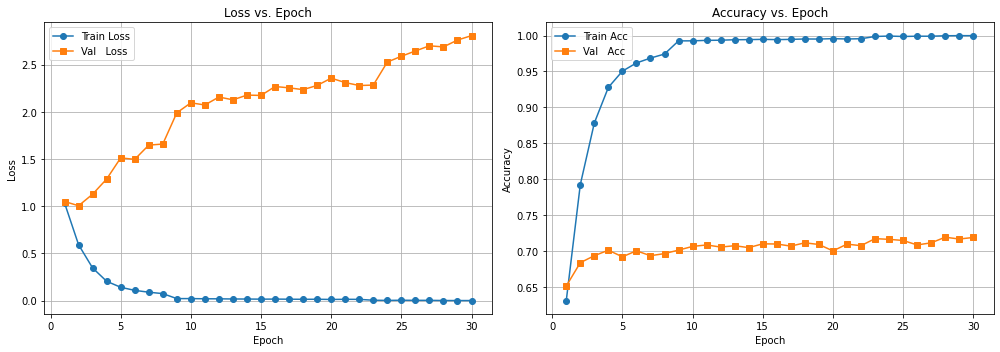

In [10]:
# ─────────────────────────────────────────────────────────────────────────────
# (1) 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ─────────────────────────────────────────────────────────────────────────────
# (2) history.csv 읽기
history = pd.read_csv('history.csv')

# ─────────────────────────────────────────────────────────────────────────────
# (3) Figure & Subplots 생성
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 3-1) 손실(Loss) 곡선
axes[0].plot(history['epoch'], history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['epoch'], history['val_loss'],   label='Val   Loss', marker='s')
axes[0].set_title('Loss vs. Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# 3-2) 정확도(Accuracy) 곡선
axes[1].plot(history['epoch'], history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['epoch'], history['val_acc'],   label='Val   Acc', marker='s')
axes[1].set_title('Accuracy vs. Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
# ─────────────────────────────────────────────────────────────────────────────


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from torch.utils.data import TensorDataset, DataLoader

# --- 설정 (train_resnet.py와 일치시키거나 필요에 따라 수정) ---
TEST_DIR       = '/home/work/AIprogramming/Ai_proj/data_generator/test_data' # 테스트 데이터 .pt 파일 경로
MODEL_PATH     = './checkpoints/best_resnet18.pth' # 학습된 모델 가중치 경로
DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE     = 1 # 시각화를 위해 배치 크기 1로 설정
NUM_WORKERS    = 0 # 노트북 환경에서는 0으로 설정하는 것이 안전할 수 있음

# CIFAR-10 정규화 파라미터 (train_resnet.py에서 사용한 값과 동일해야 함)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2023, 0.1994, 0.2010)

# --- 데이터 로딩 함수 (train_resnet.py에서 가져옴) ---
def load_pt_folder(pt_dir):
    """폴더의 .pt 파일 전부 읽어서 하나의 TensorDataset으로 반환"""
    imgs_list, labels_list = [], []
    # 여기서는 시각화를 위해 하나의 파일만 로드하거나 일부만 로드하도록 수정 가능
    pt_files = sorted(glob.glob(os.path.join(pt_dir, '*.pt')))
    if not pt_files:
        raise FileNotFoundError(f"No .pt files found in {pt_dir}")

    print(f'Loading {pt_files[0]} for visualization...') # 첫 번째 파일만 로드
    imgs, lbls = torch.load(pt_files[0], map_location=DEVICE) # 장치 지정하여 로드
    return TensorDataset(imgs, lbls)

# --- 이미지 정규화 해제 및 시각화 함수 ---
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

def imshow(img_tensor, title=None):
    """Tensor 이미지를 받아서 plt로 보여주는 함수"""
    # 정규화 해제
    img = denormalize(img_tensor.cpu().detach().clone(), CIFAR10_MEAN, CIFAR10_STD)
    # CPU로 이동, numpy 변환, 채널 축 변경 (C, H, W) -> (H, W, C)
    img = img.squeeze(0).permute(1, 2, 0).numpy()
    # 값 범위를 [0, 1]로 클리핑
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# --- PGD 공격 함수 ---
def pgd_attack(model, images, labels, eps=8/255, alpha=2/255, iters=7):
    """PGD 공격 수행 함수"""
    images = images.clone().detach().to(DEVICE)
    labels = labels.clone().detach().to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()

    adv_images = images.clone().detach()

    for _ in range(iters):
        adv_images.requires_grad = True
        outputs = model(adv_images)

        model.zero_grad()
        cost = loss_fn(outputs, labels)
        cost.backward()

        # FGSM과 유사하게 그래디언트 방향으로 이미지 업데이트
        adv_images = adv_images.detach() + alpha * adv_images.grad.sign()
        # 원본 이미지 주변의 epsilon 거리 내로 projection (클리핑)
        delta = torch.clamp(adv_images - images, min=-eps, max=eps)
        # 정규화된 이미지의 유효 범위 [0, 1]은 아니지만, 입력 데이터의 통계적 범위 내로 제한하는 것이 일반적
        # 여기서는 정규화된 상태에서의 픽셀 값 범위를 명시적으로 클램핑하진 않음 (보통 eps 자체가 작음)
        # 대신, 원본과의 차이(delta)를 제한
        adv_images = torch.clamp(images + delta, min=images.min(), max=images.max()).detach() # 실제 픽셀 범위 클램핑은 denormalize 후 해야 함

    return adv_images

# --- 메인 시각화 로직 ---
def visualize_adversarial_attack(model_path, test_dir, device):
    # 1. 데이터 로드
    try:
        test_ds = load_pt_folder(test_dir)
        # pin_memory는 CPU에서만 의미가 있을 수 있음
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=(device.type == 'cpu'))
    except FileNotFoundError as e:
        print(e)
        print("Please ensure test data exists and path is correct.")
        return
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # 2. 모델 로드
    model = models.resnet18(weights=None) # Use weights=None
    model.fc = nn.Linear(model.fc.in_features, 10) # Assuming 10 classes for CIFAR-10
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded from {model_path}")
    except FileNotFoundError:
        print(f"Error: Model weights not found at {model_path}")
        print("Please train the model first using train_resnet.py or provide the correct path.")
        return
    except Exception as e:
        print(f"Error loading model weights: {e}")
        return

    model.to(device)
    model.eval() # 평가 모드로 설정

    # 3. 샘플 이미지 가져오기
    try:
        images, labels = next(iter(test_loader))
    except StopIteration:
        print("Test loader is empty. No data to visualize.")
        return

    img_idx = 0 # 첫 번째 이미지 선택
    clean_image = images[img_idx:img_idx+1].to(device) # 배치 차원 유지
    true_label = labels[img_idx].item()

    # 4. PGD 공격 수행
    # eps 값은 학습 시 사용한 값 또는 발표 목적에 맞게 조절
    adv_image = pgd_attack(model, clean_image, labels[img_idx:img_idx+1], eps=8/255, alpha=2/255, iters=10)

    # 5. 예측 수행
    with torch.no_grad():
        clean_output = model(clean_image)
        adv_output = model(adv_image)
        clean_pred = clean_output.argmax(1).item()
        adv_pred = adv_output.argmax(1).item()

    # 6. 시각화
    perturbation = adv_image - clean_image

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    imshow(clean_image, f"Original\nTrue: {true_label}, Pred: {clean_pred}")

    plt.subplot(1, 3, 2)
    # 섭동 시각화: 절대값을 취하고 스케일링하여 보기 좋게 만듦
    perturbation_viz = perturbation.abs()
    perturbation_viz = (perturbation_viz - perturbation_viz.min()) / (perturbation_viz.max() - perturbation_viz.min() + 1e-6) # 0~1 스케일링
    # 섭동은 정규화 해제 없이 시각화 (미묘한 노이즈 패턴 확인 목적)
    plt.imshow(perturbation_viz.squeeze(0).permute(1, 2, 0).cpu().numpy())
    plt.title(f"Perturbation (Scaled)\nEps: {8/255:.3f}")
    plt.axis('off')


    plt.subplot(1, 3, 3)
    imshow(adv_image, f"Adversarial\nTrue: {true_label}, Pred: {adv_pred}")

    plt.tight_layout()
    plt.show()

Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/clean.pt for visualization...
Model loaded from ./checkpoints/best_resnet18.pth


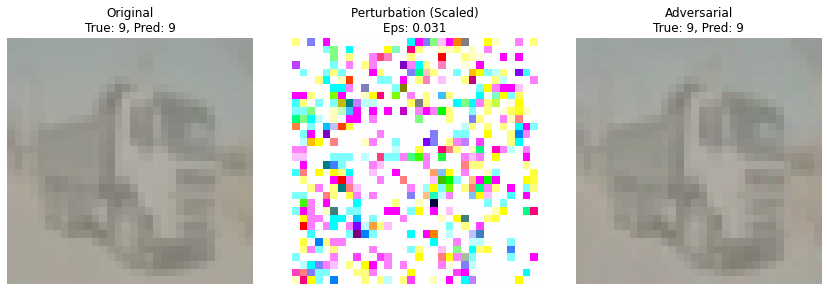

In [49]:
visualize_adversarial_attack(MODEL_PATH, TEST_DIR, DEVICE)

Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/clean.pt for visualization...
Model loaded from ./checkpoints/best_resnet18.pth
Target layer for Grad-CAM: layer4


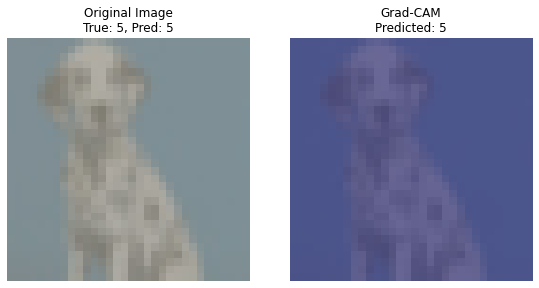

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import cv2 # OpenCV 필요
import os
import glob
from torch.utils.data import TensorDataset, DataLoader

# --- 설정 (모듈 1과 유사하게 설정) ---
TEST_DIR        = '/home/work/AIprogramming/Ai_proj/data_generator/test_data' # 테스트 데이터 .pt 파일 경로
MODEL_PATH      = './checkpoints/best_resnet18.pth' # 학습된 모델 가중치 경로
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE      = 1 # 시각화를 위해 배치 크기 1로 설정
NUM_WORKERS     = 0
TARGET_LAYER_NAME = 'layer4' # Grad-CAM을 적용할 ResNet-18의 레이어 이름 (보통 마지막 conv 블록)

# CIFAR-10 정규화 파라미터 (모듈 1과 동일)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2023, 0.1994, 0.2010)

# --- 데이터 로딩 함수 (모듈 1과 동일) ---
def load_pt_folder(pt_dir):
    """폴더의 .pt 파일 전부 읽어서 하나의 TensorDataset으로 반환"""
    imgs_list, labels_list = [], []
    pt_files = sorted(glob.glob(os.path.join(pt_dir, '*.pt')))
    if not pt_files:
        raise FileNotFoundError(f"No .pt files found in {pt_dir}")
    print(f'Loading {pt_files[0]} for visualization...') # 첫 번째 파일만 로드
    imgs, lbls = torch.load(pt_files[0], map_location=DEVICE) # 장치 지정하여 로드
    return TensorDataset(imgs, lbls)


# --- 이미지 정규화 해제 및 시각화 함수 (모듈 1과 동일) ---
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

def preprocess_image_for_viz(img_tensor):
    """시각화를 위해 이미지 텐서 전처리 (정규화 해제, numpy 변환, 채널 변경)"""
    img = denormalize(img_tensor.cpu().detach().clone(), CIFAR10_MEAN, CIFAR10_STD)
    img = img.squeeze(0).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    return img

# --- Grad-CAM 구현 ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook 등록
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook) # Use register_full_backward_hook

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        # grad_output[0] contains the gradients for the output of the layer
        self.gradients = grad_output[0].detach()


    def __call__(self, x, class_idx=None):
        self.model.eval() # Ensure model is in eval mode
        self.model.zero_grad() # Zero gradients before forward pass

        # 순전파 수행
        output = self.model(x)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # 선택된 클래스에 대한 역전파
        # Create a one-hot vector for the target class
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True) # Pass the one-hot vector as gradient

        if self.gradients is None or self.activations is None:
             print("Warning: Gradients or activations not captured. Check hook registration and backward pass.")
             return None

        # 그래디언트 GAP(Global Average Pooling) 계산 -> 각 채널의 가중치
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)

        # 가중치와 활성화 맵 곱하기 (Weighted sum)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)

        # ReLU 적용 (음수 값 제거)
        cam = F.relu(cam)

        # 히트맵 크기를 원본 이미지 크기로 리사이즈 (cv2 사용)
        # Need to move CAM to CPU and convert to numpy for cv2
        cam_np = cam.squeeze().cpu().numpy()
        # Ensure the image dimensions match the input tensor x's H, W
        target_size = (x.shape[3], x.shape[2]) # (Width, Height) for cv2.resize
        cam_resized = cv2.resize(cam_np, target_size)


        # 0~1 사이로 정규화
        cam_normalized = (cam_resized - np.min(cam_resized)) / (np.max(cam_resized) - np.min(cam_resized) + 1e-6)

        return cam_normalized, class_idx

def show_cam_on_image(img_np, mask, title=None):
    """원본 이미지 위에 Grad-CAM 히트맵을 오버레이하여 보여주는 함수"""
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # Matplotlib은 RGB 순서 사용
    heatmap = np.float32(heatmap) / 255

    # 원본 이미지와 히트맵 결합
    superimposed_img = heatmap * 0.4 + img_np * 0.6 # 가중치 조절 가능
    superimposed_img = np.clip(superimposed_img, 0, 1) # 값 범위 유지

    plt.imshow(superimposed_img)
    if title:
        plt.title(title)
    plt.axis('off')

# --- 메인 시각화 로직 ---
def visualize_grad_cam(model_path, test_dir, device, target_layer_name):
    # 1. 데이터 로드
    try:
        test_ds = load_pt_folder(test_dir)
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=(device.type == 'cpu'))
    except FileNotFoundError as e:
        print(e)
        return
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # 2. 모델 로드
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 10)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded from {model_path}")
    except FileNotFoundError:
        print(f"Error: Model weights not found at {model_path}")
        return
    except Exception as e:
        print(f"Error loading model weights: {e}")
        return
    model.to(device)
    model.eval()

    # 3. Grad-CAM 적용 대상 레이어 찾기
    try:
        # 이름으로 레이어 찾기 (예: 'layer4'는 ResNet의 네 번째 스테이지)
        target_layer = dict(model.named_modules())[target_layer_name]
        print(f"Target layer for Grad-CAM: {target_layer_name}")
    except KeyError:
        print(f"Error: Target layer '{target_layer_name}' not found in the model.")
        print("Available layers:", [name for name, _ in model.named_modules()])
        return

    # 4. Grad-CAM 객체 생성
    grad_cam = GradCAM(model=model, target_layer=target_layer)

    # 5. 샘플 이미지 가져오기
    try:
        images, labels = next(iter(test_loader))
    except StopIteration:
        print("Test loader is empty.")
        return

    img_idx = 0 # 첫 번째 이미지 선택
    input_tensor = images[img_idx:img_idx+1].to(device) # 배치 차원 유지
    true_label = labels[img_idx].item()

    # 6. Grad-CAM 계산
    mask, predicted_class = grad_cam(input_tensor)

    if mask is None:
        print("Grad-CAM mask generation failed.")
        return

    # 7. 시각화
    img_np = preprocess_image_for_viz(input_tensor)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original Image\nTrue: {true_label}, Pred: {predicted_class}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    show_cam_on_image(img_np, mask, f"Grad-CAM\nPredicted: {predicted_class}")

    plt.tight_layout()
    plt.show()

# --- 실행 ---
visualize_grad_cam(MODEL_PATH, TEST_DIR, DEVICE, TARGET_LAYER_NAME)

In [14]:
# --- Clean 데이터로만 정확도 평가 ---
from torch.utils.data import TensorDataset, DataLoader

# 1) clean 데이터 로드 (.pt 파일 경로는 환경에 맞게 수정)
clean_imgs, clean_labels = torch.load(
    '/home/work/AIprogramming/Ai_proj/data_generator/test_data/clean.pt'
)

# 2) DataLoader 생성
clean_loader = DataLoader(
    TensorDataset(clean_imgs, clean_labels),
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 3) 평가 모드 & no_grad
model.eval()
correct = 0
total   = 0
with torch.no_grad():
    for imgs, labels in clean_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds   = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

# 4) 결과 출력
clean_acc = correct / total
print(f"Clean Accuracy: {clean_acc*100:.2f}%")


Clean Accuracy: 72.83%


In [52]:
import torch
import torch.nn as nn
import torchvision.models as models
import os
import glob
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd # 결과 저장을 위해 추가 (선택 사항)

# --- 설정 (train_resnet.py 및 이전 모듈과 일치) ---
TEST_DIR        = '/home/work/AIprogramming/Ai_proj/data_generator/test_data' # .pt 파일들이 있는 경로
MODEL_PATH      = './checkpoints/best_resnet18.pth' # 학습된 모델 가중치 경로
DEVICE          = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE      = 128 # 평가 시 사용할 배치 크기 (메모리에 맞게 조절)
NUM_WORKERS     = 4   # 데이터 로딩 워커 수

# --- 특정 .pt 파일 로딩 함수 ---
def load_specific_pt_file(filepath, device):
    """주어진 경로의 .pt 파일을 읽어 TensorDataset으로 반환"""
    print(f"Loading {filepath}...")
    try:
        # map_location을 사용하여 바로 지정된 장치로 로드
        imgs, lbls = torch.load(filepath, map_location=device)
        print(f"Loaded {len(imgs)} images from {os.path.basename(filepath)}.")
        return TensorDataset(imgs, lbls)
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"Error loading file {filepath}: {e}")
        return None

# --- 메인 평가 로직 ---
def evaluate_accuracy_per_type(model_path, test_dir, device):
    # 1. 모델 로드 (train_resnet.py와 동일한 구조)
    model = models.resnet18(weights=None) # Use weights=None
    model.fc = nn.Linear(model.fc.in_features, 10) # CIFAR-10 가정 (10 클래스)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded from {model_path}")
    except FileNotFoundError:
        print(f"Error: Model weights not found at {model_path}")
        print("Please ensure the model is trained and the path is correct.")
        return
    except Exception as e:
        print(f"Error loading model weights: {e}")
        return

    model.to(device)
    model.eval() # 평가 모드로 설정

    results = {} # 결과를 저장할 딕셔너리

    # 2. test_dir 내의 모든 .pt 파일 찾기
    pt_files = sorted(glob.glob(os.path.join(test_dir, '*.pt')))

    if not pt_files:
        print(f"No .pt files found in {test_dir}. Cannot evaluate accuracy.")
        return

    print(f"\n--- Evaluating Accuracy for each data type in {test_dir} ---")

    # 3. 각 .pt 파일에 대해 평가 수행
    for filepath in pt_files:
        # 파일 이름에서 데이터 유형 추출 (예: 'clean.pt' -> 'clean')
        data_type = os.path.basename(filepath).replace('.pt', '')

        # 데이터 로드
        dataset = load_specific_pt_file(filepath, device)
        if dataset is None:
            continue # 파일 로드 실패 시 다음 파일로

        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

        # 정확도 계산
        correct = 0
        total = 0
        with torch.no_grad(): # 그래디언트 계산 비활성화
            for images, labels in dataloader:
                # DataLoader에서 로드 시 device 지정 안했으므로 여기서 이동
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                predicted = outputs.argmax(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total if total > 0 else 0
        results[data_type] = accuracy
        print(f"Accuracy on '{data_type}' data: {accuracy:.2f}% ({correct}/{total})")

    print("--- Evaluation Complete ---")
    return results

# --- 실행 ---
accuracy_results = evaluate_accuracy_per_type(MODEL_PATH, TEST_DIR, DEVICE)

# --- 결과 출력 및 저장 (선택 사항) ---
if accuracy_results:
    print("\nSummary of Accuracies:")
    for data_type, acc in accuracy_results.items():
        print(f"- {data_type}: {acc:.2f}%")

    # 결과를 DataFrame으로 만들어 CSV로 저장
    # df_results = pd.DataFrame(list(accuracy_results.items()), columns=['DataType', 'Accuracy'])
    # results_csv_path = './accuracy_summary.csv'
    # df_results.to_csv(results_csv_path, index=False)
    # print(f"\nAccuracy summary saved to {results_csv_path}")

Model loaded from ./checkpoints/best_resnet18.pth

--- Evaluating Accuracy for each data type in /home/work/AIprogramming/Ai_proj/data_generator/test_data ---
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/clean.pt...
Loaded 10000 images from clean.pt.
Accuracy on 'clean' data: 72.85% (7285/10000)
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/cw.pt...
Loaded 10000 images from cw.pt.
Accuracy on 'cw' data: 72.85% (7285/10000)
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/fgsm.pt...
Loaded 10000 images from fgsm.pt.
Accuracy on 'fgsm' data: 71.24% (7124/10000)
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/mifgsm.pt...
Loaded 10000 images from mifgsm.pt.
Accuracy on 'mifgsm' data: 70.38% (7038/10000)
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/pgd.pt...
Loaded 10000 images from pgd.pt.
Accuracy on 'pgd' data: 71.67% (7167/10000)
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_

In [1]:
import os
import glob
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader
from robustbench import load_model

# --- 설정 ---
TEST_DIR    = '/home/work/AIprogramming/Ai_proj/data_generator/test_data'  # .pt 파일들이 있는 경로
MODEL_PATH  = './checkpoints/best_resnet18.pth'                            # 직접 학습한 모델 가중치
BATCH_SIZE  = 128
NUM_WORKERS = 4

# CUDA 가능하면 GPU, 아니면 CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- .pt 파일 로드 헬퍼 ---
def load_specific_pt_file(filepath, device):
    print(f"Loading {filepath} ...")
    try:
        imgs, lbls = torch.load(filepath, map_location=device)
        print(f"  Loaded {len(imgs)} samples.")
        return TensorDataset(imgs, lbls)
    except FileNotFoundError:
        print(f"  Error: File not found -> {filepath}")
    except Exception as e:
        print(f"  Error loading {filepath}: {e}")
    return None

# --- 평가 루틴 ---
def evaluate_accuracy_per_type(model_path, test_dir, device):
    # 1) 모델 준비
    if os.path.isfile(model_path):
        # (A) 사용자 학습 모델 로드
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 10)
        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state)
        print(f"Loaded custom ResNet18 from {model_path}")
    else:
        # (B) RobustBench Standard 모델 폴백
        print(f"Custom model not found at {model_path}, loading RobustBench 'Standard' model.")
        model = load_model(
            model_name='Standard',
            dataset='cifar10',
            threat_model='Linf'
        )
    model = model.to(device).eval()

    results = {}
    pt_files = sorted(glob.glob(os.path.join(test_dir, '*.pt')))
    if not pt_files:
        print(f"No .pt files in {test_dir}")
        return results

    # 2) 각 공격셋(.pt)별 정확도 평가
    for filepath in pt_files:
        data_type = os.path.basename(filepath).replace('.pt','')
        ds = load_specific_pt_file(filepath, device)
        if ds is None:
            continue
        loader = DataLoader(ds, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=NUM_WORKERS,
                            pin_memory=True)
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total   += labels.size(0)
        acc = 100.0 * correct / total if total>0 else 0.0
        results[data_type] = acc
        print(f"[{data_type:10s}] Accuracy: {acc:6.2f}% ({correct}/{total})")

    print("Evaluation complete.")
    return results

# --- 실행 ---
if __name__ == "__main__":
    accuracy_results = evaluate_accuracy_per_type(MODEL_PATH, TEST_DIR, DEVICE)
    if accuracy_results:
        print("\nSummary:")
        for dtype, acc in accuracy_results.items():
            print(f"  {dtype:10s}: {acc:6.2f}%")


Loaded custom ResNet18 from ./checkpoints/best_resnet18.pth
Loading /home/work/AIprogramming/Ai_proj/data_generator/test_data/clean.pt ...
  Loaded 10000 samples.


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataset.py", line 178, in __getitem__
    return tuple(tensor[index] for tensor in self.tensors)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataset.py", line 178, in <genexpr>
    return tuple(tensor[index] for tensor in self.tensors)
RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
